# Data preparation

In [62]:
from glob import glob
from sklearn.model_selection import train_test_split

goggles = glob('scripts/images/safety_goggles/*.jpg')
helmates = glob('scripts/images/safety_helmate/*.jpg')

goggle_train, goggle_test = train_test_split(goggles, test_size=0.20)
helmate_train, helmate_test = train_test_split(helmates, test_size=0.20)

TRAIN_DIR = 'train'
TEST_DIR = 'test'

In [63]:
!mkdir train

!mkdir train/Goggle
files = ' '.join(goggle_train)
!mv $files train/Goggle

!mkdir train/Helmate
files = ' '.join(helmate_train)
!mv $files train/Helmate

In [64]:
!mkdir test

!mkdir test/Goggle
files = ' '.join(goggle_test)
!mv $files test/Goggle

!mkdir test/Helmate
files = ' '.join(helmate_test)
!mv $files test/Helmate

# Plot some random images from the dataset.

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

goggles = np.random.choice(goggle_train, 13)
helmates = np.random.choice(helmate_train, 12)
data = np.concatenate((goggles, helmates))
labels = 13 * ['Cat'] + 12 *['Dog']

N, R, C = 25, 5, 5
plt.figure(figsize=(12, 9))
for k, (src, label) in enumerate(zip(data, labels)):
    im = Image.open(src).convert('RGB')
    plt.subplot(R, C, k+1)
    plt.title(label)
    plt.imshow(np.asarray(im))
    plt.axis('off')

# Model customization

In [66]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3, preprocess_input

CLASSES = 2
    
# setup model
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D(name='avg_pool')(x)
x = Dropout(0.4)(x)
predictions = Dense(CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
   
# transfer learning
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [67]:
predictions

<tf.Tensor 'dense_10/Softmax:0' shape=(None, 2) dtype=float32>

# Data augmentation

In [68]:
from keras.preprocessing.image import ImageDataGenerator

WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 32

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 294 images belonging to 2 classes.
Found 74 images belonging to 2 classes.


# Plot some images result of data augmentation.

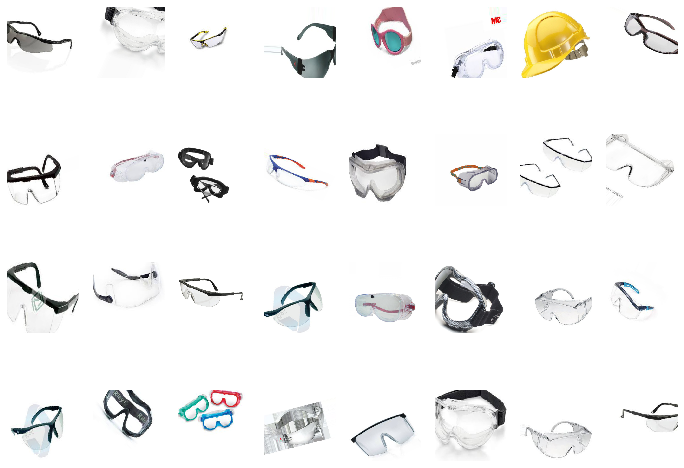

In [69]:
x_batch, y_batch = next(train_generator)

plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    plt.subplot(4, 8, k+1)
    plt.imshow((img + 1) / 2)
    plt.axis('off')

# Transfer learning

In [70]:
EPOCHS = 5
BATCH_SIZE = 32
STEPS_PER_EPOCH = 320
VALIDATION_STEPS = 64

MODEL_FILE = 'object_detection_1.model'

history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Epoch 1/5
320/320 [==============================] - 1508s 5s/step - loss: 0.0338 - accuracy: 0.9905 - val_loss: 0.0624 - val_accuracy: 0.9912
Epoch 2/5
320/320 [==============================] - 1628s 5s/step - loss: 0.0054 - accuracy: 0.9982 - val_loss: 3.0994e-06 - val_accuracy: 0.9950
Epoch 3/5
320/320 [==============================] - 1640s 5s/step - loss: 0.0078 - accuracy: 0.9987 - val_loss: 1.3113e-07 - val_accuracy: 0.9930
Epoch 4/5
320/320 [==============================] - 1587s 5s/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.1177 - val_accuracy: 0.9912
Epoch 5/5
320/320 [==============================] - 1725s 5s/step - loss: 0.0046 - accuracy: 0.9989 - val_loss: 1.4901e-08 - val_accuracy: 0.9981


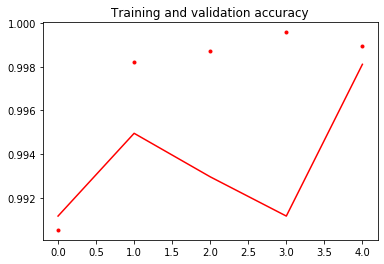

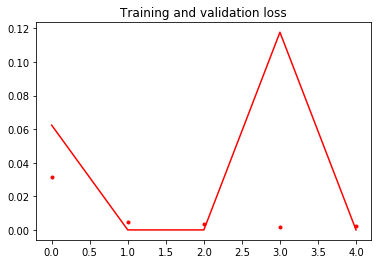

In [75]:
def plot_training(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')
  
  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()
  
plot_training(history)